In [1]:
#For ignoring warning
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.stem import WordNetLemmatizer
import unidecode
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
tqdm.pandas()
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import json



# Dataset Overview

In [3]:
train = pd.read_json("../input/whats-cooking-kernels-only/train.json")
test = pd.read_json("../input/whats-cooking-kernels-only/test.json")

In [4]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [6]:
print(train.shape)                 
print(train.columns)

(39774, 3)
Index(['id', 'cuisine', 'ingredients'], dtype='object')


In [7]:
print(test.shape)                 
print(test.columns)

(9944, 2)
Index(['id', 'ingredients'], dtype='object')


In [8]:
train.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

No missing values

* We have 39774 unique recipes from different cuisines in the train set
* We have 9944 unique recipes from different cuisines in the test set
* We have ingredients list

# **Exploratory data Analysis**

# Target Feature- cuisine

Our target feature is the cuisine

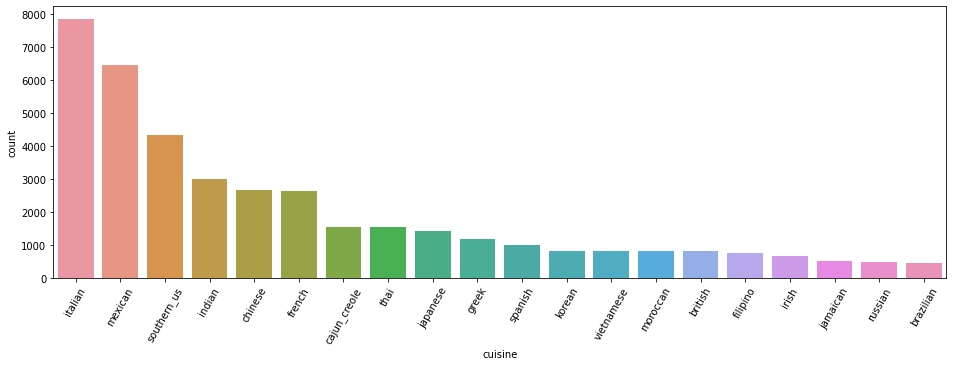

In [9]:
plt.figure(figsize=(16,5))
plt.xticks(rotation=60)
ax= sns.countplot(x='cuisine', data= train, order = train['cuisine'].value_counts().index)
#print(train.cuisine.value_counts())



From the countplot we can observe that most recipes were from italian cuisine, followed by mexican, southern_us.

# Great ingredients make great food

In [10]:
print('Maximum Number of Ingredients in a recipe: ',train['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a recipe: ',train['ingredients'].str.len().min())

Maximum Number of Ingredients in a recipe:  65
Minimum Number of Ingredients in a recipe:  1


There seems to be recipe that contains only one ingredient.

**Lets create a feature that stores number of ingredients**

In [11]:
#no of Ingredients
train['ing_count'] = train['ingredients'].str.len()

Text(0.5, 1.0, 'kdeplot of ingredient count')

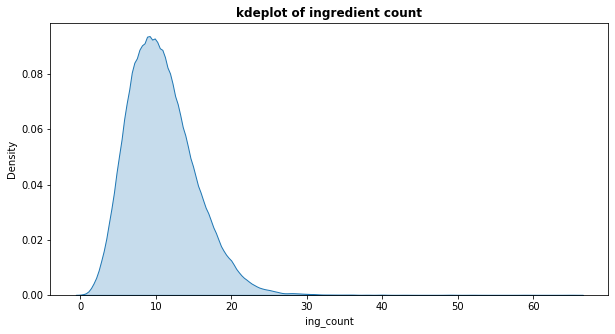

In [12]:
#distribution of number of ingredients
plt.figure(figsize=(10,5))
sns.kdeplot(data=train["ing_count"], shade=True)
plt.title('kdeplot of ingredient count',fontweight="bold")

ingredient count is right skewed

<AxesSubplot:xlabel='ing_count', ylabel='count'>

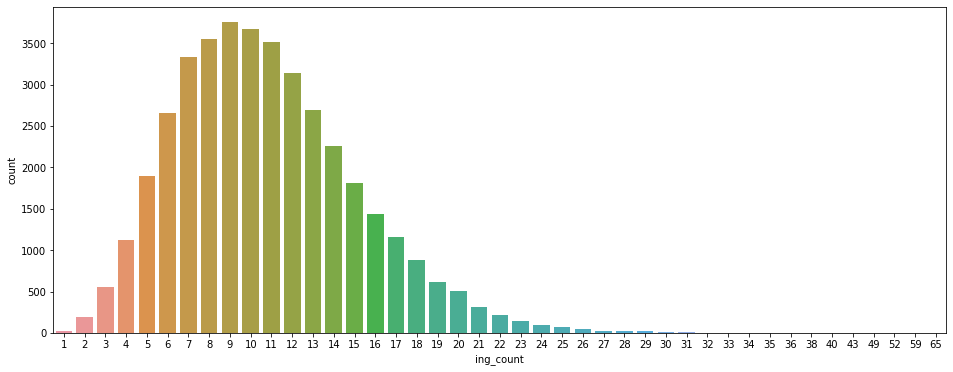

In [13]:
plt.figure(figsize=(16,6))
sns.countplot(x='ing_count', data= train)

We can see recipes with 1 or 2 ingredients. Then there are recipes with more than 30 ingredients. These are outliers and get adversely affect our model. But the thing is that,there are recipes with this number of ingredients.

**Lets look at the unbelievable ingredients**

In [14]:
train[train['ing_count'] >= 40]

,id,cuisine,ingredients,ing_count
345,45039,thai,"[fish sauce, hot red pepper flakes, cider vine...",40
3359,21624,indian,"[red chili peppers, fresh coriander, fresh gin...",40
6449,6548,southern_us,"[canned black beans, seasoned bread crumbs, pr...",40
10513,49282,mexican,"[condensed cream of chicken soup, pepper, refr...",49
15289,3885,italian,"[fettucine, fresh marjoram, minced garlic, oli...",65
22906,2253,indian,"[white vinegar, sparkling lemonade, coconut su...",49
26103,13049,mexican,"[vanilla ice cream, lime, garlic powder, zucch...",52
30350,13430,brazilian,"[marshmallows, fresh corn, cheddar cheese, shr...",59
31250,29216,italian,"[eggs, warm water, pepper, dried basil, unsalt...",43


The 65 ingredient recipe is from italian cuisine.

In [15]:
train[train['ing_count'] <= 1]

,id,cuisine,ingredients,ing_count
940,4734,japanese,[sushi rice],1
2088,7833,vietnamese,[dried rice noodles],1
6787,36818,indian,[plain low-fat yogurt],1
7011,19772,indian,[unsalted butter],1
8181,16116,japanese,[udon],1
8852,29738,thai,[sticky rice],1
8990,41124,indian,[butter],1
10506,32631,mexican,[corn tortillas],1
13178,29570,thai,[grained],1
17804,29849,southern_us,[lemonade concentrate],1


We can see a japanese cuisine with just water as the ingredient. What can that be??

**Most common ingredients**

In [16]:
# Taking Out all the ingredients in the dataset and storing in a list
ingredients_list = [ing for ingredients in train['ingredients'] for ing in ingredients]

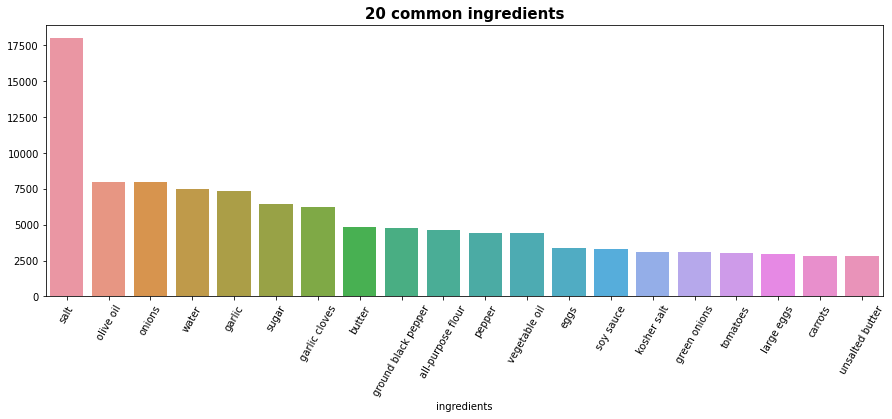

In [17]:
from collections import Counter
ingredients_count = pd.Series(dict(Counter(','.join(ingredients_list).split(',')))).sort_values(ascending=False)
top20ingredients = ingredients_count.head(20)

plt.figure(figsize=(15,5))
sns.barplot(x= top20ingredients.index, y=top20ingredients)
plt.xticks(rotation=60)
plt.title('20 common ingredients', fontsize=15, fontweight='bold')
plt.xlabel('ingredients')
plt.show()

It is not suprising to find salt as the most common ingredients. We can also find olive oil, onions, water as common ingredients.

# Preprocessing

**Remove outliers**

In [18]:
train = train[train['ing_count'] > 1]
train = train[train['ing_count']<60]

**Basic cleaning**

In [19]:
lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients = ' '.join(ingredients)
    ingredients = ingredients.lower() #Convert to lowercase
    ingredients = re.sub('[,\.!?:()"]', '',ingredients) # remove punctuation marks 
    ingredients = re.sub('[^a-zA-Z"]',' ',ingredients) # remove all strings that contain a non-letter
    ingredients = ingredients.replace('-', ' ')
    words = []
    for word in ingredients.split():
        word = re.sub("[0-9]"," ",word) #removing numbers
        word = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', word) # Removing Units
        if len(word) <= 2: continue
        word = unidecode.unidecode(word)
        word = lemmatizer.lemmatize(word)
        if len(word) > 0: words.append(word)
    return ' '.join(words)


In [20]:
train['x'] = train['ingredients'].progress_apply(preprocess)
test['x'] = test['ingredients'].progress_apply(preprocess)
train.head()

100%|██████████| 9944/9944 [00:02<00:00, 4960.59it/s]


,id,cuisine,ingredients,ing_count,x
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


# Final Model

Before Predictive modelling,we need to convert words to numeric values. We can use TfidfVectorizer.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True) 
# sublinear_tf scaling addresses the problem that 20 occurrences of a word is probably not 20 times more important than 1 occurrence

In [22]:
X_train = vectorizer.fit_transform(train['x'].values)
X_train.sort_indices()
X_test = vectorizer.transform(test['x'].values)

In [23]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(train['cuisine'].values)

In [24]:
classifier = SVC(C=100, # penalty parameter
                 kernel='rbf', # kernel type, rbf working fine here
                 degree=3, # default value
                 gamma=1, # kernel coefficient
                 coef0=1, # change to 1 from default value of 0.0
                 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 #decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)

In [25]:
model = OneVsRestClassifier(classifier, n_jobs=4)
model.fit(X_train, Y_train)

OneVsRestClassifier(estimator=SVC(C=100, coef0=1, gamma=1), n_jobs=4)

OneVsRest is a heuristic method for using binary classification algorithms for multi-class classification.

In [26]:
Y_test = model.predict(X_test)
Y_pred = label_encoder.inverse_transform(Y_test)

In [27]:
test_id = test['id']
submission = pd.DataFrame({'id': test_id, 'cuisine': Y_pred}, columns=['id', 'cuisine'])
submission.to_csv('submission.csv', index=False)

In [28]:
submission.head()

,id,cuisine
0,18009,irish
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian
